# Esercitazione 6 - Modello di Ising 1D

## 1 Obiettivo

L'obiettivo di questa esercitazione è la simulazione di un sistema di particelle, descritto dal modello di Ising 1D, con tecniche Monte Carlo. Gli esercizi proposti richiedono di modificare un codice fornitoci, implementando il campionamento richiesto per la simulazione. Questo viene effettuato sia con l'algoritmo di Metropolis sia mediante campionamento di Gibbs. 
Viene inoltre richiesto di permettere la ripartenza da una configurazione precedente e di aggiungere la misurazione di alcune quantità fisiche del sistema che si sta simulando.

In definitiva il codice sarà in grado di fornire misure dell'energia potenziale, del calore specifico, della suscettibilità magnetica e della magnetizzazione del sistema.

Si eseguirà quindi una simulazione di un sistema di 50 spin (con J=1) nel range di temperatura [0.5, 2]K. I risultati ottenuti saranno confrontati con le relazioni analitiche.

## 2 Cenni teorici e metodologie utilizzate

Il moodello di Ising è un modello di potenziale che descrive l'interazione tra particelle dovuta al loro spin.
In questa esercitazione verrà considerato il caso unidimensionale. Il sistema è costituito da N particelle, disposte lungo una retta, aventi la possibilità di assumere i valori di spin discreti +1 o -1. L'Hamiltoniana di interazione proposta dal modello di Ising è la seguente:

$$
H = 
-J\sum_{i=1}^N s_i s_{i+1}
-\frac{h}{2}\sum_{i=1}^N (s_i + s_{i+1}) 
$$

Dove le variabili $s_i$ contengono gli stati di spin delle rispettive particelle, e assumono valori +1 o -1. Vengono inoltre assunte condizioni al contorno periodiche per le quali $s_{N+1} = s_1$. La variabile $h$ rappresenta un campo magnetico esterno con cui gli spin possono interagire.

Il caso unidimensionale, studiato in questo esercizio, ha la particolarità di permettere la determinazione di soluzioni analitiche. Queste sono implementate nelle seguenti funzioni.

In [1]:
from IPython.display import display, Latex
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

J = 1.0
Ns = 50

def energy(T):
    beta = 1/T
    th = np.tanh(J/T)
    thN= th**Ns
    ch = 1/th
    e = -J*( th + ch*thN )/( 1 + thN )
    return e

def heatc(T):
    beta = 1/T
    th = np.tanh(J/T)
    thN= th**Ns
    ch = 1/th
    heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
    return heat

def magnet(T):
    h=0.02 #external field
    b = 1/T
    l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
    l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
    Z = l1**Ns + l2**Ns
    M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
            + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)
    return M

def susc(T):
    beta = 1/T
    th = np.tanh(J/T)
    thN= th**Ns
    X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)
    return X
    

Le grandezze fisiche prese in esame verranno misurate utilizzando le seguenti relazioni/definizioni teoriche:
1. $U(N,T) = \langle H \rangle$
2. $C(N,T) = k_B \beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle^2)$ 
3. $\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle$
4. $M(N,T)= \langle \sum_{i=1,N}s_i \rangle$

## 3 Implementazione

Il programma realizzato esegue una simulazione del modello di Ising in 1D. Oltre alla libreria per la generazione dei numeri casuali, il codice è suddiviso in due file:
- `Monte_Carlo_ISING_1D.h`,  che contiene le dichiarazioni delle variabili globali utlizzate e i prototipi delle funzioni
- `Monte_Carlo_ISING_1D.cpp`,  che contiene l'implementazione del main() e delle altre funzioni

Le funzioni implementate sono le seguenti:
- `void Input(void)`, legge dal file _input.dat_ i valori dei parametri con cui eseguire la simulazione. Inoltre inizializza il generatore di numeri casuali e alcune variabili utili. Se richiesto nel file _input.dat_ il generatore di numeri casuali viene inizializzato con i valori di _seed.out_ in modo da poter proseguire una sequenza precedente.
- `void Init()`, genera la configurazione iniziale degli spin in modo casuale o legge, se opportunamente richiesto, una configurazione precedentemente salvata in _config.final_. Infine esegue l'equilibrazione richiamando `Move(metro)` un numero di volte pari a `eq_steps`.
- `void Move(int metro)`, se il parametro `metro` è uguale a `1` viene utilizzato l'algoritmo di Metropolis altrimenti l'algoritmo di Gibbs. Una singola mossa dell'algoritmo di Metropolis corrisponde, in questo esercizio, alla scelta di una delle particelle casualmente con probabilità uniforme per la quale viene proposta l'inversione dello spin. Viene poi valutata la probabilità di accettazione per questa mossa pari a 
$$
\text{min}[1; e^{-\beta(E_\nu-E_\mu)}]
$$
dove $E_\nu - E_\mu$ rappresenta la differenza di energia tra la configurazione finale con lo spin scelto invertito e quella iniziale. Per l'algoritmo di Gibbs invece una singola mossa corrisponde alla scelta di una delle particelle casualmente e con probabilità uniforme il cui spin $s_k$ viene modificato indipendentemente dal suo valore iniziale con probabilità
$$
p(s'_k = \pm 1|\{s_j : j \neq k\}) = \frac{1}{1+exp(\beta\Delta E)}
$$
in questo caso $\Delta E$ rappresenta invece la differenza di energia tra la configurazione con lo spin scelto pari a $\pm 1$ e quella con lo spin scelto pari a $\mp 1$.
In entrambi i casi vengono eseguite un numero di mosse pari al numero di particelle simulate di modo che richiamando una volta `Move()` sia mediamente proposta la modifica dello spin per ciascuna particella.
- `double Boltzmann(int sm, int ip)`, calcola l'energia associata allo spin di indice `ip` il cui valore è `sm` secondo il modello di Ising 1D. Nella sua implementazione viene usata la funzione `Pbc()` per implementare le condizioni al contorno periodiche nella determinazione degli spin primi vicini. 
- `int Pbc(int i)`, implementa le condizioni al contorno periodiche
- `double flip(double spin)`, restituisce il valore di spin opposto a quello passatogli
- `void Measure()`, esegue le misure di energia, energia al quadrato, magnetizzazione e magnetizzazione al quadrato salvandone i valori in un array.
- `void Accumulate(void)`, somma i valori calcolati in `Measure()` in un array di accumulatori e aggiorna un contatore che fornisce il numero di misure accumulate.
- `void Averages(int iblk)`, esegue le medie di blocco, le medie di tutte le medie di blocco precedenti e calcola le relative incertezze salvandole su file. Stampa informazioni sull'avanzamento della simulazione.
- `void ConfFinal(void)`, salva la configurazione finale sul file `config.final` e le stime finali con relative incertezze delle grandezze calcolate su `output.allFinal.0`. 
- `double Error(double sum, double sum2, int iblk)`, calcola l'incertezza statistica di una misura conoscendone il numero di misure (`iblk`), la loro somma (`sum`) e la somma dei loro quarati (`sum2`). Utilizzata per valutare le incertezze statistiche in `Averages()`.
- `void Reset(int iblk)`, ripristina a 0 tutti gli accumulatori di blocco

Ho modificato il programma in modo tale che possa eseguire un numero di simulazioni specificato in input a diverse temperature, da una temperatura iniziale ad una temperatura finale. Se si vogliono eseguire simulazioni ad una sola temperatura fissata basta impostare la stessa temperatura iniziale e finale e specificare poi il numero di simulazioni desiderato. All'interno del main viene innanzitutto richiamata `Input()`, è quindi presente un ciclo su tutte le simulazioni a diversa temperatura. 
Per ogni temperatura fissata la simulazione consiste nei seguenti passaggi:
```
per ogni blocco:
    Reset()
    per ogni step:
        Move(metro)
        Measure()
        Accumulate()
    Averages()
ConfFinal()
```

## 4 Utilizzo

Tutti i file utilizzati per l'input e output sono contenuti all'interno della cartella `io/`. 
Il programma deve essere eseguito senza nessun argomento. Tutte le impostazioni necessarie ad eseguire la simulazione sono lette dal file `io/input.dat`. Nelle prime linee di questo file devono essere specificati, nell'ordine
- `temp_i` - temperatura iniziale dell'intervallo di temperature in cui eseguire le simulazioni
- `temp_f` - temperatura finale dell'intervallo di temperature in cui eseguire le simulaioni
- `n_sim`  - numero di temperature diverse da esplorare all'interno dell'intervallo specificato, gli estremi sono sempre compresi
- `nspin` - numero di particelle, delle quali viene modificato lo spin, da simulare
- `J` - omonimo parametro dell'Hamiltoniana del modello di Ising
- `h` - campo magnetico esterno
- `metro` - se uguale a 0 viene utilizzato l'algoritmo di Gibbs, se uguale a 1 l'algoritmo di Metropolis
- `nblk` - numero di blocchi per il procedimento della "media a blocchi" utilizzato
- `nstep` - numero di volte che viene richiamata l'operazione `Move()` (step) in ciascun blocco
- `restart` - se uguale a 1 vengono utilizzati i file `config.final` e `seed.out` per eseguire una simulazione ricominciando da dove si era conclusa una precedente simulazione

Il file `output.Final.0` contiene i risultati finali di ciascuna simulazione a temperatura differente, le colonne hanno il seguente significato

`temperatura - energia - errore energia - capacità termica - errore capacità termica - magnetizzazione - errore magnetizzazione - suscettibilità magnetica - errore suscettibilità magnetica`

Gli altri file, con nomi nel formato `output.grandezza.0`, contengono le misure di ciascuna grandezza con tutti gli aggiornamenti blocco per blocco. In questo caso le colonne hanno il seguente significato

`numero del blocco - media di blocco - media delle medie fino a questo blocco - errore`

## 5 Fase di equilibrazione

Sia l'algoritmo di Metropolis sia quello di Gibbs forniscono un campionamento che rispecchia la densità di probabilità desiderata solo asintoticamente. È quindi necessaria una fase iniziale di equilibrazione durante la quale il sistema raggiunge la configurazione di equilibrio e l'algoritmo di campionamento raggiunge la condizione di asintoticità desiderata. 
Nel programma questa fase è implementata eseguendo un certo numero di mosse dell'algoritmo di Metropolis prima di iniziare la fase di misurazione. Per valutare il numero di mosse necessario a raggiungere l'equilibrio ho eseguito una simulazione alla temperatura di 0.3 K valutando l'andamento di una grandezza fisica come, ad esempio, l'energia.

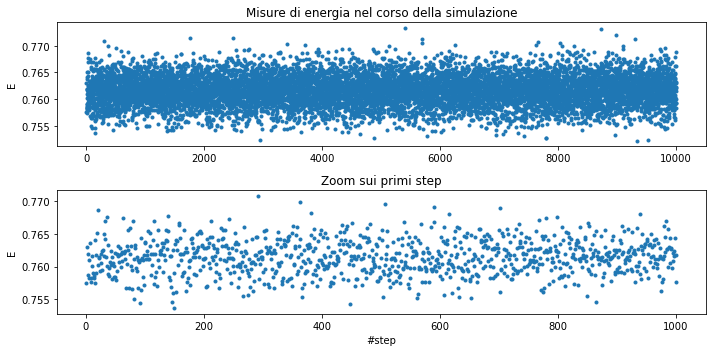

In [2]:
from IPython.display import display, Latex
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

i, u = np.genfromtxt('../06/ISING_1D/equili/output.ene.0', usecols=(0,1), unpack=True)
fig, axes = plt.subplots(2,1)
fig.set_size_inches(10,5)
axes[0].scatter(i,u, marker='.')
axes[1].scatter(i[:1000],u[:1000], marker='.')
axes[1].set_ylabel('E')
axes[0].set_ylabel('E')
axes[1].set_xlabel('#step')
axes[0].set_title('Misure di energia nel corso della simulazione')
axes[1].set_title('Zoom sui primi step')
plt.tight_layout()
plt.show()

Si può osservare come a questa temperatura il sistema appaia già equilibrato fin dai primi step. 
Uno step consiste in N step Monte Carlo, in modo tale da avere mediamente dato a tutti gli spin la possibilità di invertire il loro stato. La convergenza dell'algoritmo allo stato di equilibrio è quindi molto veloce.

La temperatura di 0.3K è una delle minori tra quelle utilizzate nelle simulazioni successive. Per garantire il raggiungimento della situazione di equilibrio in tutte le simulazioni successive le misure sul sistema vengono avviate dopo aver eseguito "a vuoto" 100 passi. Nella simulazione con cui ho ottenuto il grafico precedente questa fase di equilibrazione è stata rimossa.

## 6 Risultati

### 6.1 h=0
I risultati presentati in questo paragrafo sono stati ottenuti da simulazioni eseguite a 10 temperature diverse di un sistema uno-dimensionale costituito da 50 particelle il cui spin può variare. L'interazione è descritta dal modello di Ising con J=1. In questo caso viene posto h=0, questo corrisponde alla simulazione di un sistema in assenza di campo magnetico esterno.

Per ciascuna simulazione sono stati utilizzati $10^5$ step divisi in 20 blocchi. I risultati presentati sono i valori finali ottenuti considerando tutti i blocchi.

Le simulazioni sono state eseguite utilizzando sia l'algoritmo di Metropolis sia il campionamento di Gibbs.

Nei grafici seguenti sono mostrati i risultati ottenuti e messi a confronto i due metodi di campionamento utilizzati. Negli stessi grafici viene anche rappresentata la curva teorica ottenuta analiticamente.

I risultati sono in unità adimensionali per le quali $k_B=1$ e $\mu_B=1$

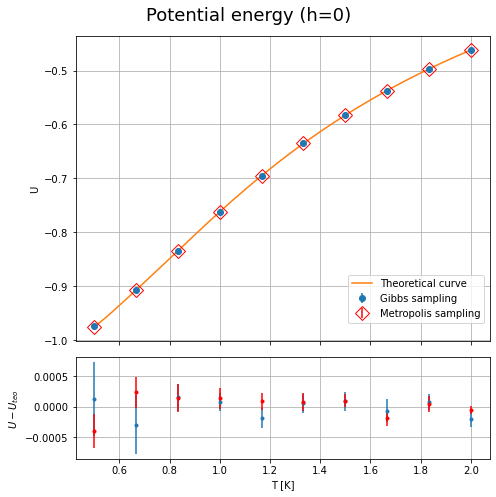

In [3]:
g_t, g_u, g_erru, g_c, g_errc, g_m, g_errm, g_x, g_errx  = np.genfromtxt('../06/ISING_1D/gibbsH0_simulationResults/output.allFinal.0', usecols=range(0,9), unpack=True)
m_t, m_u, m_erru, m_c, m_errc, m_m, m_errm, m_x, m_errx  = np.genfromtxt('../06/ISING_1D/metroH0_simulationResults/output.allFinal.0', usecols=range(0,9), unpack=True)
t_theo = np.arange(0.5,2, 0.01)

fig, (p1, p2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.set_size_inches(7, 7)
fig.suptitle('Potential energy (h=0)', size=18)
p1.errorbar(g_t, g_u, g_erru, fmt='o', label='Gibbs sampling')
p1.errorbar(m_t, m_u, m_erru, fmt='D', markersize=10, mfc='none',label='Metropolis sampling', color='red')
p1.plot(t_theo, energy(t_theo), label='Theoretical curve')
p1.set(ylabel = 'U')

#fit dei dati con una funzione f = k sqrt(n)
p2.errorbar(g_t, g_u-energy(g_t), g_erru, fmt='.')
p2.errorbar(m_t, m_u-energy(m_t), m_erru, fmt='.', color='red')
p2.set(xlabel='T [K]', ylabel = '$U-U_{teo}$')
p2.grid()

p1.grid()

fig.legend(loc=(0.7,0.35))
plt.tight_layout()
plt.show()

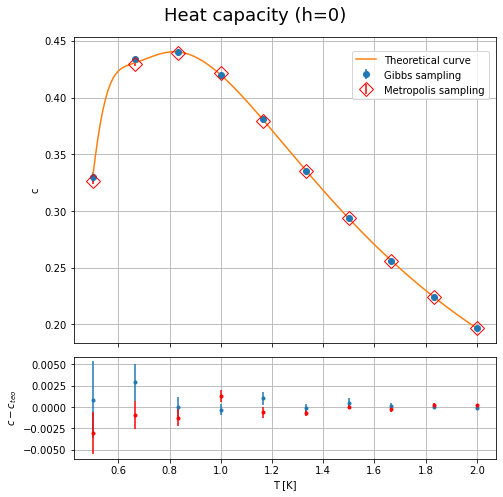

In [4]:
fig, (p1, p2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.set_size_inches(7, 7)
fig.suptitle('Heat capacity (h=0)', size=18)
p1.errorbar(g_t, g_c, g_errc, fmt='o', label='Gibbs sampling')
p1.errorbar(m_t, m_c, m_errc, fmt='D', markersize=10, mfc='none',label='Metropolis sampling', color='red')
p1.plot(t_theo, heatc(t_theo), label='Theoretical curve')
p1.set(ylabel = 'c')

#fit dei dati con una funzione f = k sqrt(n)
p2.errorbar(g_t, g_c-heatc(g_t), g_errc, fmt='.')
p2.errorbar(m_t, m_c-heatc(m_t), m_errc, fmt='.', color='red')
p2.set(xlabel='T [K]', ylabel = '$c-c_{teo}$')
p2.grid()

p1.grid()

fig.legend(loc=(0.7,0.8))
plt.tight_layout()
plt.show()

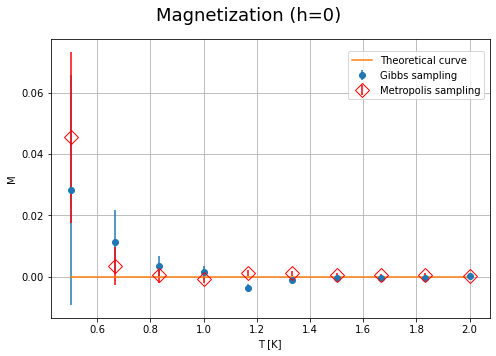

In [5]:
fig = plt.gcf()
fig.set_size_inches(7, 5)
fig.suptitle('Magnetization (h=0)', size=18)
plt.errorbar(g_t, g_m, g_errm, fmt='o', label='Gibbs sampling')
plt.errorbar(m_t, m_m, m_errm, fmt='D', markersize=10, mfc='none',label='Metropolis sampling', color='red')
plt.plot(t_theo, 0*t_theo, label='Theoretical curve')
plt.ylabel('M')
plt.xlabel('T [K]')

plt.grid()

fig.legend(loc=(0.7,0.72))
plt.tight_layout()
plt.show()

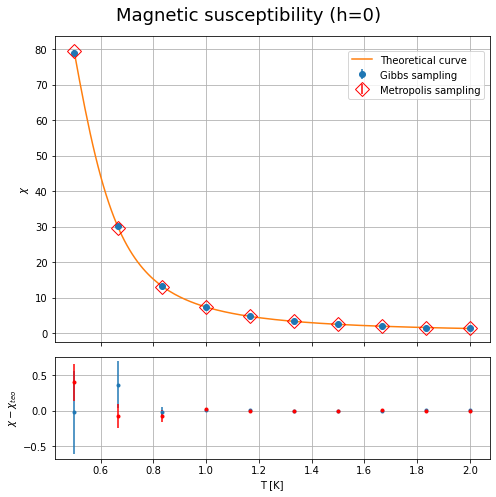

In [6]:
fig, (p1, p2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.set_size_inches(7, 7)
fig.suptitle('Magnetic susceptibility (h=0)', size=18)
p1.errorbar(g_t, g_x, g_errx, fmt='o', label='Gibbs sampling')
p1.errorbar(m_t, m_x, m_errx, fmt='D', markersize=10, mfc='none',label='Metropolis sampling', color='red')
p1.plot(t_theo, susc(t_theo), label='Theoretical curve')
p1.set(ylabel = '$\chi$')

#fit dei dati con una funzione f = k sqrt(n)
p2.errorbar(g_t, g_x-susc(g_t), g_errx, fmt='.')
p2.errorbar(m_t, m_x-susc(m_t), m_errx, fmt='.', color='red')
p2.set(xlabel='T [K]', ylabel = '$\chi-\chi_{teo}$')
p2.grid()

p1.grid()

fig.legend(loc=(0.7,0.8))
plt.tight_layout()
plt.show()

### 6.2 h=0.02

Ho eseguito anche alcune simulazioni a diverse temperature con il valore di h non nullo. Questa condizione corrisponde alla presenza di un campo magnetico esterno che interagisce con gli spin del sistema. La grandezza fisica più interessante in queste condizioni è la magnetizzazione che descrive le proprietà magnetiche del sistema.

La magnetizzazione misurata in queste simulazioni in funzione della temperatura è mostrata nel grafico seguente

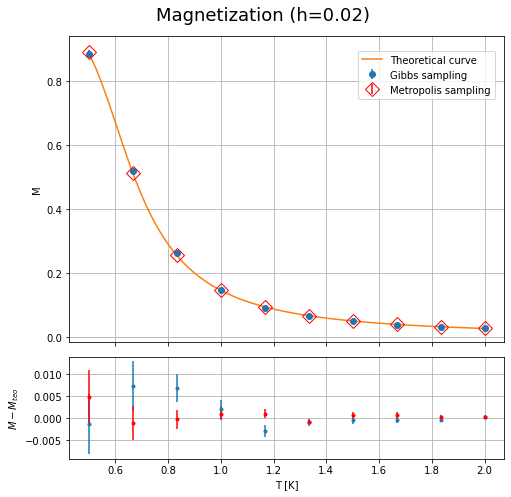

In [7]:
g_t, g_m, g_errm = np.genfromtxt('../06/ISING_1D/gibbsH02_simulationResults/output.allFinal.0', usecols=(0,5,6), unpack=True)
m_t, m_m, m_errm = np.genfromtxt('../06/ISING_1D/metroH02_simulationResults/output.allFinal.0', usecols=(0,5,6), unpack=True)

fig, (p1, p2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.set_size_inches(7, 7)
fig.suptitle('Magnetization (h=0.02)', size=18)
p1.errorbar(g_t, g_m, g_errm, fmt='o', label='Gibbs sampling')
p1.errorbar(m_t, m_m, m_errm, fmt='D', markersize=10, mfc='none',label='Metropolis sampling', color='red')
p1.plot(t_theo, magnet(t_theo), label='Theoretical curve')
p1.set(ylabel = 'M')

#fit dei dati con una funzione f = k sqrt(n)
p2.errorbar(g_t, g_m-magnet(g_t), g_errm, fmt='.')
p2.errorbar(m_t, m_m-magnet(m_t), m_errm, fmt='.', color='red')
p2.set(xlabel='T [K]', ylabel = '$M-M_{teo}$')
p2.grid()

p1.grid()

fig.legend(loc=(0.7,0.8))
plt.tight_layout()
plt.show()

## 7 Conclusione

I risultati ottenuti sono tutti in buon accordo, entro le incertezze, con le curve analitiche. Nelle simulazioni a temperature più basse si può notare una distanza di qualche $\sigma$ tra le misure e il valore teorico di alcune grandezze. Inoltre si può osservare come l'incertezza sulle misure sia maggiore a basse temperature.

L'efficacia del metodo di simulazione utilizzato è quindi dipendente dalla temperatura. Non sono state osservate inoltre sostanziali differenze tra i due metodi di campionamento.